In [1]:
import random

import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, join
import astropy.units as u

# My progs
from myprogs.vlbi.ts_func import get_ts
from tool_func import calc_orient, random_walk
from linear_fit import linfit2d
from myprogs.catalog.read_icrf import read_icrf3
from myprogs.StatsFunc.rms_calc import rms_calc
from myprogs.catalog.pos_diff import radio_cat_diff_calc

np.random.seed(3)

In [2]:
ts_dir = "/Users/Neo/Astronomy/data/vlbi/nju/series-10step"
sou_list_file = "{}/sou_list_4_ts.txt".format(ts_dir)
mean_pos_file = "../data/yearly-mean-position-from-ts-nju-10step-rw.txt"
crf_dir = "../data/yearly-ts-nju-10step-rw"

In [3]:
# Source list
sou_list = Table.read(sou_list_file , format="ascii")
icrf3_def = Table.read("../data/icrf3sx-def-sou.txt", format="ascii")
sou_list = join(sou_list, icrf3_def)

In [4]:
# sample_size = 1
# sou_rw = random.choices(icrf3_def["iers_name"], k=sample_size)[0]
sou_rw = "0552+398"

In [5]:
def calc_wmean(x, err):
    """Calculate the weighted mean.
    """

    if len(x) == 1:
        wmean,  wmerr = x[0], err[0]
    else:
        wmean = np.dot(x, err**-2) / np.sum(err**-2)
        wmerr = np.sum(1/err) / np.sum(err**-2)

    return wmean, wmerr

In [6]:
# Output
f_out = open(mean_pos_file, "w")

print("iers_name, year, num_ses, ra, ra_err, dec, dec_err, ra_dec_corr", file=f_out)

N = len(sou_list)
i = 0

# Annually average the source positions
for soui in sou_list["iers_name"]:

    coordts = get_ts(soui, ts_dir)
    ra0, dec0 = np.median(coordts["ra"]), np.median(coordts["dec"])

    if soui == sou_rw:
        # Add random walk process to the coordinate time series for this source
        dra_rw, ddec_rw = random_walk(coordts["jyear"], t_scale=5, sigma_var=3)

        # Mas -> deg
        coordts["ra"] = ra0 + dra_rw / 3.6e6
        coordts["dec"] = dec0 + ddec_rw / 3.6e6

    # Caculate the annual mean position
    for year in range(1979, 2021):
        coordts2 = coordts[((coordts["jyear"] >= year) & (coordts["jyear"] < year+1))]

        if len(coordts2) >= 1:
            ra0, ra0_err = calc_wmean(coordts2["ra"], coordts2["ra_err"])
            dc0, dc0_err = calc_wmean(coordts2["dec"], coordts2["dec_err"])
            ra_dec_cor = np.median(coordts2["ra_dec_corr"])

            print("{:8s}, {:.0f}, {:3d}, "
                  "{:15.10f}, {:6.3f}, {:+15.10f}, {:6.3f}, {:6.3f}".format(
                      soui, year, len(coordts2),
                      ra0, ra0_err, dc0, dc0_err, ra_dec_cor), file=f_out)
    i += 1

f_out.close()

In [7]:
# Generate yearly CRF
pos_tab = Table.read(mean_pos_file, format="ascii")
for year in np.arange(1979, 2021):
    mask = (pos_tab["year"] == year)
    sub_tab = pos_tab[mask]

    if len(sub_tab):
        sub_tab.write("{:s}/{:d}.dat".format(crf_dir, year),
                      format="ascii.csv", overwrite=True)

In [8]:
icrf3sx = read_icrf3(wv="sx")

icrf3def = icrf3sx[icrf3sx["type"] == "D"]

In [9]:
years = np.concatenate(([1984], np.arange(1986, 2021)))
# years = np.concatenate((np.arange(1979, 2021)))
num = len(years)


In [10]:
N0_d = np.zeros_like(years)
N1_d = np.zeros_like(years)
pmt_d = np.empty((num, 8), dtype=float)
err_d = np.empty((num, 8), dtype=float)

In [11]:
for i, year in enumerate(years):
    
    ts_sou = Table.read("{}/{:d}.dat".format(crf_dir, year), format="ascii")
    
    
    # Add unit information
    ts_sou["ra"].unit = u.deg
    ts_sou["dec"].unit = u.deg
    ts_sou["ra_err"].unit = u.mas
    ts_sou["dec_err"].unit = u.mas
    
    # ICRF3 defining sources
    pos_oft = radio_cat_diff_calc(ts_sou, icrf3def, sou_name="iers_name")
    N0_d[i], N1_d[i], pmt_d[i], err_d[i] = calc_orient(pos_oft)

/Users/Neo/scisoft/opt64/lib/python3.9/site-packages/myprogs/catalog/pos_diff.py:275: RuntimeWarning: divide by zero encountered in true_divide
  ratio1 = (eema1 / eena1)**2


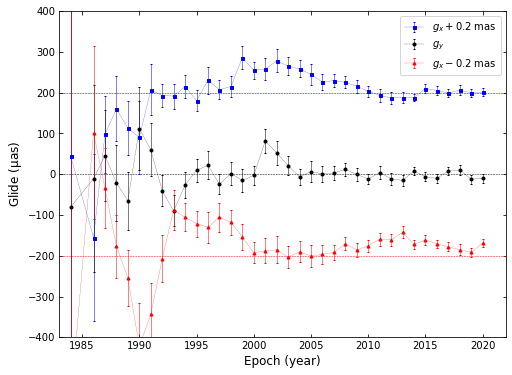

In [12]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.hlines(200, 1979, 2025, ls="dashed", color="b", lw=0.5)
ax.hlines(0, 1979, 2025, ls="dashed", color="k", lw=0.5)
ax.hlines(-200, 1979, 2025, ls="dashed", color="r", lw=0.5)

ax.errorbar(years,
            pmt_d[:, 0] + 200,
            yerr=err_d[:, 0],
            color="blue",
            ms=3,
            fmt="-s",
            elinewidth=0.5,
            lw=0.2,
            label="$g_x+0.2$ mas",
            capsize=1)
ax.errorbar(years,
            pmt_d[:, 1],
            yerr=err_d[:, 1],
            color="black",
            ms=3,
            fmt="-o",
            elinewidth=0.5,
            lw=0.2,
            label="$g_y$",
            capsize=1)
ax.errorbar(years,
            pmt_d[:, 2] - 200,
            yerr=err_d[:, 2],
            color="red",
            ms=3,
            fmt="-^",
            elinewidth=0.5,
            lw=0.2,
            label="$g_x-0.2$ mas",
            capsize=1)

ax.set_xlabel("Epoch (year)", fontsize=12)
ax.set_ylabel("Glide ($\mathrm{\mu as}$)", fontsize=12)

ax.axis([1983, 2022, -400, 400])
# plt.title("Glide from 10-step solution", fontsize=15)
ax.legend()
# plt.savefig("../plots/glide-from-yearly-ts-nju-rw.eps")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


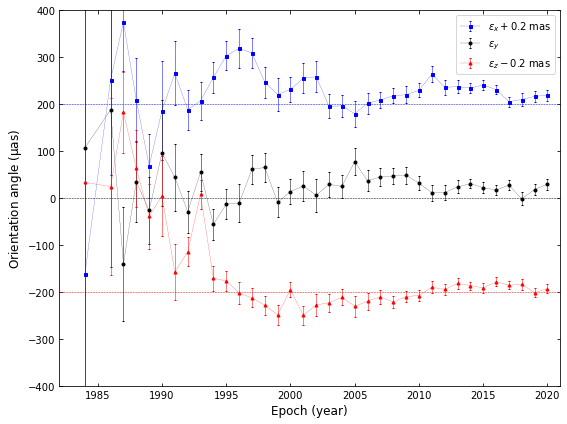

In [13]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.hlines(200, 1979, 2021, ls="dashed", color="b", lw=0.5)
ax.hlines(0, 1979, 2021, ls="dashed", color="k", lw=0.5)
ax.hlines(-200, 1979, 2021, ls="dashed", color="r", lw=0.5)

ax.errorbar(years,
            pmt_d[:, 3] + 200 - 36,
            yerr=err_d[:, 3],
            color="blue",
            ms=3,
            fmt="-s",
            elinewidth=0.5,
            lw=0.2,
            label="$\\epsilon_x+0.2$ mas",
            capsize=1)
ax.errorbar(years,
            pmt_d[:, 4] + 52,
            yerr=err_d[:, 4],
            color="black",
            ms=3,
            fmt="-o",
            elinewidth=0.5,
            lw=0.2,
            label="$\\epsilon_y$",
            capsize=1)
ax.errorbar(years,
            pmt_d[:, 5] - 200 + 10,
            yerr=err_d[:, 5],
            color="red",
            ms=3,
            fmt="-^",
            elinewidth=0.5,
            lw=0.2,
            label="$\\epsilon_z-0.2$ mas",
            capsize=1)

ax.axis([1982, 2021, -400, 400])
ax.set_xlabel("Epoch (year)", fontsize=12)
ax.set_ylabel("Orientation angle ($\mathrm{\mu as}$)", fontsize=12)
ax.legend()

plt.tight_layout()
plt.savefig("../plots/orient-from-yearly-ts-nju-rw.eps")

In [14]:
wx = pmt_d[:, 3]
wy = pmt_d[:, 4]
wz = pmt_d[:, 5]

wx_err = err_d[:, 3]
wy_err = err_d[:, 4]
wz_err = err_d[:, 5]

In [15]:
wmean1, wrms1, wstd1 = rms_calc(wx)
wmean2, wrms2, wstd2 = rms_calc(wy)
wmean3, wrms3, wstd3 = rms_calc(wz)

print("Rotation statistics (No weighted)")
print("    Mean   RMS  Std")
print("    uas    uas  uas")
print("R1  {:+4.0f}  {:4.0f}  {:.0f}".format(wmean1, wrms1, wstd1))
print("R2  {:+4.0f}  {:4.0f}  {:.0f}".format(wmean2, wrms2, wstd2))
print("R3  {:+4.0f}  {:4.0f}  {:.0f}".format(wmean3, wrms3, wstd3))


wmean1, wrms1, wstd1 = rms_calc(wx, wx_err)
wmean2, wrms2, wstd2 = rms_calc(wy, wy_err)
wmean3, wrms3, wstd3 = rms_calc(wz, wz_err)

print("\nRotation statistics (Weighted)")
print("    Mean  WRMS Std")
print("    uas   uas  uas")
print("R1  {:+4.0f}  {:.0f}  {:.0f}".format(wmean1, wrms1, wstd1))
print("R2  {:+4.0f}  {:.0f}  {:.0f}".format(wmean2, wrms2, wstd2))
print("R3  {:+4.0f}  {:.0f}  {:.0f}".format(wmean3, wrms3, wstd3))

Rotation statistics (No weighted)
    Mean   RMS  Std
    uas    uas  uas
R1   +57   100  82
R2   -25    57  51
R3   +37   110  103

Rotation statistics (Weighted)
    Mean  WRMS Std
    uas   uas  uas
R1   +63  67  23
R2   -27  33  18
R3    -4  29  29


In [16]:
year_start = 1995
mask = (years >= year_start)

In [17]:
wmean1, wrms1, wstd1 = rms_calc(wx[mask])
wmean2, wrms2, wstd2 = rms_calc(wy[mask])
wmean3, wrms3, wstd3 = rms_calc(wz[mask])

print("Rotation statistics (No weighted, Remove data < {:d})".format(year_start))
print("    Mean   RMS  Std")
print("    uas    uas  uas")
print("R1  {:+4.0f}  {:4.0f}  {:.0f}".format(wmean1, wrms1, wstd1))
print("R2  {:+4.0f}  {:4.0f}  {:.0f}".format(wmean2, wrms2, wstd2))
print("R3  {:+4.0f}  {:4.0f}  {:.0f}".format(wmean3, wrms3, wstd3))

wmean1, wrms1, wstd1 = rms_calc(wx[mask], wx_err[mask])
wmean2, wrms2, wstd2 = rms_calc(wy[mask], wy_err[mask])
wmean3, wrms3, wstd3 = rms_calc(wz[mask], wz_err[mask])

print("Rotation statistics (Weighted, Remove data < {:d})".format(year_start))
print("    Mean  WRMS Std")
print("    uas   uas  uas")
print("R1  {:+4.0f}  {:.0f}  {:.0f}".format(wmean1, wrms1, wstd1))
print("R2  {:+4.0f}  {:.0f}  {:.0f}".format(wmean2, wrms2, wstd2))
print("R3  {:+4.0f}  {:.0f}  {:.0f}".format(wmean3, wrms3, wstd3))

Rotation statistics (No weighted, Remove data < 1995)
    Mean   RMS  Std
    uas    uas  uas
R1   +71    80  35
R2   -26    35  23
R3   -15    26  21
Rotation statistics (Weighted, Remove data < 1995)
    Mean  WRMS Std
    uas   uas  uas
R1   +63  67  21
R2   -26  30  15
R3    -8  18  17
